# Devoir 4 : Analyse de trains de spike d'un réseaux
---

Dans le dernier TD, nous avons vu comment générer une séquence de temps de spike (un train de spike) avec certaines caractéristiques : une probabilité constante d'émission de spike dans le temps, qui résulte dans une distribution exponentielle de temps inter-spike (ISIs), avec un CV proche de 1 (égale à 1 dans la limite des séquences très longues). 

Dans ce devoir, on va répéter l'analyse de trains spike pour une *ensemble* de neurones, c'est-à-dire pour plusieurs neurones à la fois. Cela permet notamment d'étudier le taux de décharge *instantané* de la population, qui est une moyenne sur la population de neurones dans un interval court, et non pas la moyenne sur la durée totale de l'enregistrement des spikes. 

### 0. Préparation : le `numpy.array` à deux dimensions

Vous avez déjà une notion de ce que c'est un `numpy.array` : jusqu'ici, nous nous sommes servi comme une sorte de liste d'élements avec quelques fonctions supplémentaires, notamment mathématiques. On peut facilement utiliser un array dans des opérations comme la substration, addition, multiplication etc. On peut indexer ses éléments comme dans une liste, ou par ex. `my_array[0]` désigne le premier élément.

Un autre (très) grand avantage des arrays sur les listes c'est qu'ils peuvent avoir plusieurs dimensions, comme par ex. en deux dimensions les matrices avec un certain nombre de rangés et un certain nombre de colonnes. Dans ce cas, l'indexation suit les mêmes principes, mais permet de choisir des élements individuelles, rangés, colonnes, ou sous-matrices selon le nombre d'indexes qu'on utilise. Voici quelques examples :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

a = np.array([[0,1], 
              [2,3]])

print(a)

# Avec un seul index on choisit soit 
# la rangé (rangé i avec a[i]) :
print(a[0])

# soit la colonne (colonne i avec a[:,i]) :
print(a[:,1])

# Avec deux index on choisit l'élement a_ij 
# en notation matricielle :
print(a[0,1])

# Enfin la forme ('shape') de l'array, c'est-à-dire 
# le nombre de rangés et le nombre de colonnes, est 
# donnée par 
print('The shape of our 2x2 square matrix is', a.shape, '! (Ouff, c\'est bon...)')

[[0 1]
 [2 3]]
[0 1]
[1 3]
1
The shape of our 2x2 square matrix is (2, 2) ! (Ouff, c'est bon...)


In [2]:
# On peut également créer des array 'vides'
# ou préremplies de 0 (ou 1) avec une forme 
# souhaitée :
b = np.zeros((2,4))
print(b)

# Allons remplir la première rangé de 1s
b[0] = 1.
print(b)

# et remplissons la deuxième rangé des nombre
# de 0 à 3
b[1] = np.arange(4)
print(b)


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1. 1. 1. 1.]
 [0. 0. 0. 0.]]
[[1. 1. 1. 1.]
 [0. 1. 2. 3.]]


In [3]:
# Attention : lorsque nous souhaitons attribuer 
# des valeurs à des élements d'un array, il faut 
# que les dimensions soient compatibles !
b[:,-1] = np.arange(4)
# (Ce n'est pas le cas ici...)

ValueError: could not broadcast input array from shape (4) into shape (2)

### 1. Analyse de trains de spike d'une population de neurones

Au lieu de générer une séquence de spikes pour un seul neurone, nous pouvons utiliser les "fonctionnalités matricielles" de `numpy` pour générer des spikes pour toute une population de neurones à la fois. 

Dans un premier temps, on va considérer une activité parfaitement Poissonienne avec une probabilité de décharge constante. Cela correspond à une situation d'activité **asynchrone irrégulière** dans un réseaux cortical. 

Dans une deuxième temps, on considéra une modulation temporelle de la probablité d'émission de spike, qui pourra être detectée au niveau de l'aticvité de la population. Une telle modulation pourrait par ex. avoir son origine dans d'une activité oscillante dans une autre région du cortex qui projette sur ces neurones, ou être généré spontanément dans un réseaux récurrent si l'inhibition récurrente est suffisamment forte. Ce cas correspond à un régime d'activité **synchrone irrégulière**.

**Rappel sur les nombres aléatoires :** Pour représenter "l'hasard" ou l'aléatoire dans des programmes, on peut utiliser des *générateurs de nombres aléatoires*, qui sont des algorithmes qui peuvent générer des nombres qui sont justement le plus aléatoires possibles, dans la mesure qu'ils remplissent certaines critères comme par ex. de ne pas être corrélés entre eux. Des fonctions liées aux nombres aléatoires et leur génération sont fournies par le module `numpy.random`. Généralement, on a le plus souvent besoin de générer des nombres qui sont distribué uniformenent sur l'interval $[0,1)$, pour cela il existe la fonction `np.random.uniform` : 

In [ ]:
 np.random.uniform?

In [4]:
# We can draw a 1D array of random numbers:
print(np.random.uniform(size=5))

# or, for example, a 2D array of random numbers
# distributed between 0 and 1
print(np.random.uniform(size=(2,3)))

[0.40383755 0.83169907 0.53461667 0.38694226 0.90148878]
[[0.58457235 0.03657714 0.0848701 ]
 [0.94789592 0.25287325 0.46851622]]


Text(0, 0.5, 'counts in interval')

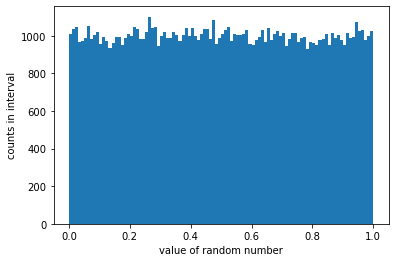

In [5]:
# Last but not least, let's verify that if 
# we generate many many random numbers, they 
# cover more or less homogeneously the interval
# between 0 and 1:
fig, ax = plt.subplots()
ax.hist(np.random.uniform(size=100000), bins=np.arange(0,1.01,0.01))
ax.set_xlabel('value of random number')
ax.set_ylabel('counts in interval')

# --> so, with a probability of p, the random number is 
# smaller than p, which is what we will use below!


Nous pouvons constater ici que ces nombres aléatoires sont avec une probabilité $p$ plus petit que $p$ - c'est exactement cette propriété que nous avons utilisé dans le dernier TD et que nous allons utiliser par la suite pour déterminer si un PA a été emis à un moment ou pas.

In [6]:
# 1) Parameters of neurons
N = 100    # number of neurons
r = 20.e-3 # firing rate in kHz (=1/ms)

# 3) Discretization of time
T = 20000. # ms
dt = 1.0 # ms
t = np.arange(0,T,dt)
nt = len(t)

# 3) Create matrix with N rows (1st index) representing the neurons
# and nt columns (2nd index) representing the time bins

# probability to record a spike -> constant, single value
# for all neurons and all times
p = dt*r

# here, activities are determined by comparing a N x nt matrix of
# random numbers between 0 and 1 with p
activities = np.random.uniform(size=(N,nt)) < p 

# NOTE: The result of a comparison is a boolean value (i.e, True 
# or False), but we can transform it in 0s and 1s by multiplying 
# with 1:
activities = 1*activities


### 1.1 Statistiques 
Calculez le taux de décharge moyen de la population de neurones (en Hz). Est-ce qu'il est en accord avec le taux spécifié ? Déterminez les temps de spike pour les $N$ neurones et déterminez pour chacun le CV et le taux de décharge. Plottez la distribution des CVs. Plottez la distribution des taux de décharge. 

Mean firing rate: 19.932 Hz


Text(0.5, 0, 'r (Hz)')

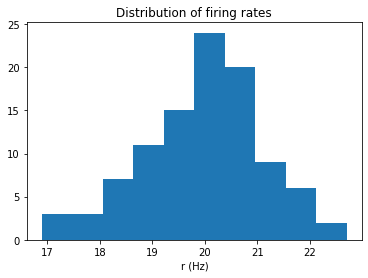

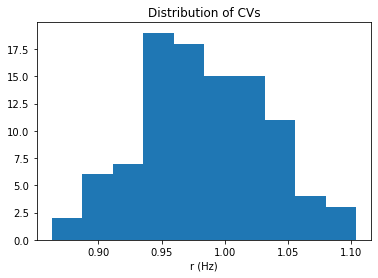

In [8]:
# mean firing rate
# (number of all spikes per time normalized by number of neurons)
r_mean = np.sum(activities)/N/T * 1000 # Hz
print('Mean firing rate:', r_mean, 'Hz')

# statistics for each neuron 
spiketimes = []
isis = []
rs = []
cvs = []

for i in range(N):
    times_per_neuron = np.where(activities[i])[0]*dt
    spiketimes.append(times_per_neuron)
    
    isis_per_neuron = np.diff(times_per_neuron)
    isis.append(isis_per_neuron)
    
    rs.append(len(times_per_neuron)/T*1000) # Hz
    cvs.append(np.std(isis_per_neuron)/np.mean(isis_per_neuron))


fig, ax = plt.subplots()
ax.set_title('Distribution of firing rates')
ax.hist(rs)
ax.set_xlabel('r (Hz)')

fig, ax = plt.subplots()
ax.set_title('Distribution of CVs')
ax.hist(cvs)

ax.set_xlabel('r (Hz)')



### 1.2 Raster plot

Une visualisation très utile de l'activité neuronale est le "raster plot", où chaque spike est représenté par un point. Ses coordonnées (x,y) représentent le temps du spike (x) et l'identité du neurone (y). Pour un seul neurone avec l'index 0 avec des spikes très réguliers tous les 20 ms cela donnerait 

Text(0, 0.5, 'neuron index')

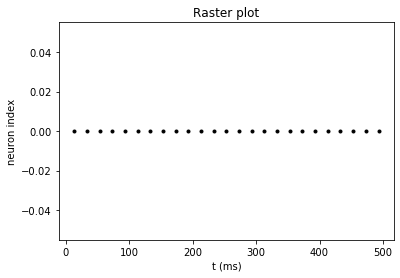

In [9]:
fake_spiketimes = np.arange(13,500,20) 
# Let's take the first spike at t=13ms, of
# course that's absolutely arbitrary!

index = 0

fig, ax = plt.subplots()
ax.set_title('Raster plot')
ax.plot(fake_spiketimes, index*np.ones(len(fake_spiketimes)), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')

Généralisez le raster plot à une population de neurones et plottez l'activité de la population de neurones étudiée plus haut. 

Text(0, 0.5, 'neuron index')

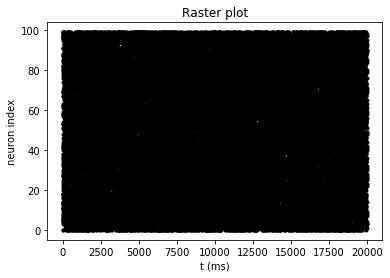

In [10]:
# raster plot for the population

# the generalization here is to plot 
# the spikes again neuron for neuron,
# i.e., loop over all spiketimes
fig, ax = plt.subplots()
ax.set_title('Raster plot')
for index in range(N):
    ax.plot(spiketimes[index], index*np.ones(len(spiketimes[index])), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')

(100, 300)

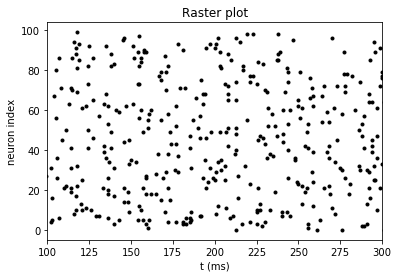

In [11]:
# raster plot for the population 
# (zoom)
fig, ax = plt.subplots()
ax.set_title('Raster plot')
for index in range(N):
    ax.plot(spiketimes[index], index*np.ones(len(spiketimes[index])), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')
ax.set_xlim(100,300)

### 1.3 L'activité de population, taux de décharge instantané

Jusqu'ici, nous avons étudié l'activité de neurones avec une décharge irrégulière mais sans variation temporelle sous-jacente. Dans ce cas, on peut s'attendre à ce qu'une moyenne sur beaucoup de neurones (par ex. 1000) sur disons 2 ms donne la même estimation du taux de décharge que la moyenne temporelle pour un neurone sur 2 s. Cela n'est plus valable si la probabilité d'émettre un spike dépend du temps. 

Dans l'exemple suivant, nous allons à nouveau considérer une modulation sinusoidale, ou la probabilité de décharge varie avec le temps selon $p = p_0 + \Delta p \sin(2\pi f_{\rm mod} t)$.

In [12]:
# 1) Parameters of neurons
N = 1000    # number of neurons

# Now, define a baseline firing rate,
# the amplitude of the variation, and 
# a modulation frequency
r0 = 10.e-3 # baseline firing rate in kHz (=1/ms)
dr = 5.e-3  # amplitude of modulation in kHz (=1/ms)
fmod = 20.e-3 # modulation frequency in kHz


# 3) Discretization of time
T = 1000. # ms
dt = 1.0 # ms
t = np.arange(0,T,dt)
nt = len(t)

# 3) Create matrix with N rows (1st index) representing the neurons
# and nt columns (2nd index) representing the time bins

# probability to record a spike -> now, time-dependent array
p = dt*(r0 + dr*np.sin(2*np.pi*fmod*t))

# here, activities are determined by comparing a N x nt matrix of
# random numbers between 0 and 1 with p
activities = np.random.uniform(size=(N,nt)) < p 

# NOTE: The result of a comparison is a boolean value (i.e, True 
# or False), but we can transform it in 0s and 1s by multiplying 
# with 1:
activities = 1*activities

Déterminez les temps de spike pour les $N$ neurones et plottez l'activité du réseau avec un raster plot. Déterminez à nouveau pour chaque neurone le CV et le taux de décharge, et plottez leurs distributions respectives. 

Mean firing rate: 9.995 Hz


/Users/jranft/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/jranft/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/jranft/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jranft/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jranft/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'CV')

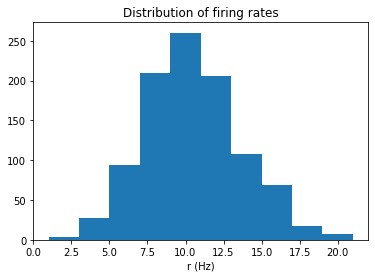

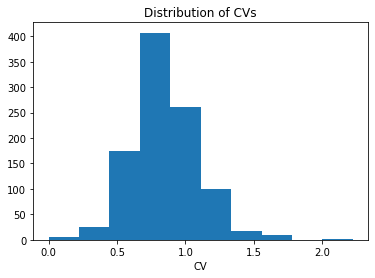

In [13]:
# mean firing rate
# (number of all spikes per time normalized by number of neurons)
r_mean = np.sum(activities)/N/T * 1000 # Hz
print('Mean firing rate:', r_mean, 'Hz')

# statistics for each neuron 
spiketimes = []
isis = []
rs = []
cvs = []

# loop over all neurons: we know how to calculate
# the statistics for a single neuron / a 1D array
# of activity
for i in range(N):
    # the activity of neuron i is one row of 
    # the complete activity matrix -> a single 
    # row is a 1D array!
    times_per_neuron = np.where(activities[i])[0]*dt
    spiketimes.append(times_per_neuron)
    
    isis_per_neuron = np.diff(times_per_neuron)
    isis.append(isis_per_neuron)
    
    rs.append(len(times_per_neuron)/T*1000) # Hz
    cvs.append(np.std(isis_per_neuron)/np.mean(isis_per_neuron))


# plot the distribution of firing rates
fig, ax = plt.subplots()
ax.set_title('Distribution of firing rates')
ax.hist(rs)
ax.set_xlabel('r (Hz)')

# plot the distribution of CVs
fig, ax = plt.subplots()
ax.set_title('Distribution of CVs')
ax.hist(cvs)
ax.set_xlabel('CV')


Text(0, 0.5, 'neuron index')

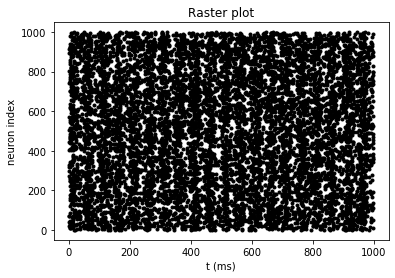

In [14]:
# raster plot for the population
fig, ax = plt.subplots()
ax.set_title('Raster plot')
for index in range(N):
    ax.plot(spiketimes[index], index*np.ones(len(spiketimes[index])), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')

(100, 300)

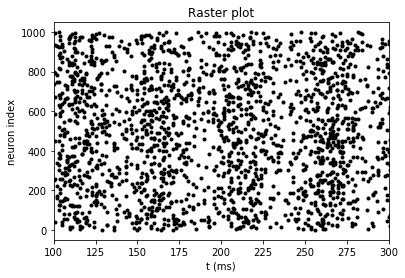

In [15]:
# raster plot for the population 
# (zoom)
fig, ax = plt.subplots()
ax.set_title('Raster plot')
for index in range(N):
    ax.plot(spiketimes[index], index*np.ones(len(spiketimes[index])), marker='.', linewidth=0, color='black')
ax.set_xlabel('t (ms)')
ax.set_ylabel('neuron index')
ax.set_xlim(100,300)

Bien que le raster plot indique que l'activité à l'échelle de la population est régulière, les CVs sont distribués autour de 1, suggérant qu'individuellement l'activité des neurones reste très irrégulière. Pour mieux analyser l'activité de la population, déterminez l'activité moyenne de la population en fonction du temps. Pour cela, utilisez des bins de 1 ms (vous pouvez choisir d'autres bins plus fins / plus larges pour comparer si vous voulez). 

Vous pourriez partir directement de la matrice contenant l'activité des neurones pour chaque bin que nous avons généré au début, et dont nous nous sommes servis pour déterminez les temps de spikes. Cepandant, la façon plus générale est de partir des $N$ trains de spike (1 pour chaque neuron) et de compter le nombre des spikes dans un bin étant emis dans le réseau.


In [16]:
# Create an empty array that you
# can use to count the spikes in
# a given bin of time [t[i], t[i+1])

# time bins (not necessarily identical to times
# used above for data generation)
dtbin = 2. # ms
tbin = np.arange(0,T,dtbin)
nbins = len(tbin)

# array for counts
counts = np.zeros(nbins)

# outer loop over all neurons
for i in range(N):
    
    # inner loop over all spike times
    # (in this version, each iteration
    # the variable time is a subsequent 
    # element of 'spiketimes[i]')
    for time in spiketimes[i]:
    
    # alternatively, do a loop over the 
    # indices to the different times:
    #for j in range(len(spiketimes[i]):
        #time = spiketimes[i][j]
    
       
        # --> for each spike, determine in which 
        # bin it belongs (i.e., where the spike should 
        # be counted)
        
        # NOTE: In order to determine the correct bin,
        # we have to determine how many multiples
        # of dtbin 'fit' into the time, i.e., how many
        # bins are already passed. This is why we have
        # to calculate 'time/dtbin'. Then, indices have
        # to be integer numbers (nombres entiers), and
        # all values in the interval [n*dtbin, (n+1)*dtbin) 
        # should land in the same bin n. Therefore, 
        # take the integer part of 'time/dtbin'
    
        bin_for_spike = int(time / dtbin)
    
        # add one spike to appropriate bin
        counts[bin_for_spike] += 1



Plottez l'activité de population en fonction du temps. Quelle valeur pour la largeur des bins (`dtbin`) vous parait bien pour faire sortir la modulation temporelle de l'activité de population, et pourquoi ? Pouvez vous trouver la bonne normalisation pour le nombre des spikes detectés dans un bin (de l'array `counts` ci-dessus) pour obtenir le taux de décharge en Hz ?

(100, 300)

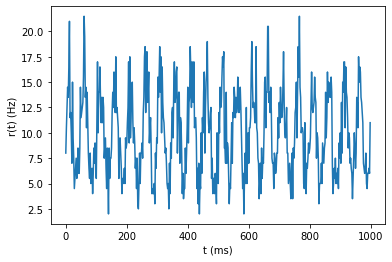

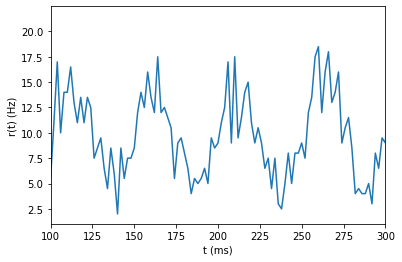

In [17]:
# normalize to population size and bin width
rates = counts/N/dtbin * 1000 # Hz

fig, ax = plt.subplots()
ax.plot(tbin, rates)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r(t) (Hz)')

fig, ax = plt.subplots()
ax.plot(tbin, rates)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r(t) (Hz)')
ax.set_xlim(100,300)

Une valeur de `dtbin=2.0` ms paraît bien pour faire sortir la modulation temporelle de la décharge. C'est un compromis à trouver entre un bin court qui permet une bonne résolution temporelle de la modulation, et un bin large qui permet d'améliorer la statistique (plus de spikes par bin collectés) et ainsi de diminuer le bruit. Comme la période de la modulation et 50 ms, avec 2 ms nous avons 25 bins pour décrire une cycle, ce qui reste une assez bonne résolution temporelle, et la modulation apparaît néanmoins clairement.

### BONUS : Génération d'un train de spike aléatoire en tirant des ISI d'une distribution exponentielle

Nous avons vu dans le dernier TD que les temps inter-spike (ou ISI) des trains de spike avec une statistique Poissonienne suivent une distribution exponentielle. Utilisez la fonction `np.random.exponential` pour générer d'abord une séquence de ISI. Cette fonction prend notamment un argument ("scale") qui détermine la valeur moyenne de la distribution. Transformez ensuite cette séquence de ISI en séquence de temps de spike. 

**Rappel :** La valeur moyenne des ISI d'un neurone correspond exactement à l'inverse de son taux de décharge.

**Attention :** Avec cette méthode, on fixe le nombre des ISI et donc le nombre des spikes, contrairement à la prémière méthode où nous avons d'abord fixé la durée d'un "enregistrement", puis déterminé après le nombre (variable) des spikes.

Essayez de générez un train de spike qui couvre l'activité pendant 20s d'un neurone qui décharge à 20Hz. Qu'est-ce que pourraient être les avantages de cette méthode (tirer aléatoirement des ISI) par rapport à la prémière (déterminer dans des bins s'il y a eu un spike ou pas) ?

In [ ]:
# the function to generate exponentially distributed
# random numbers
np.random.exponential?

In [18]:
# define parameters
rate = 20. # Hz
mean_isi = 1/rate 
Ttotal = 20. # s

# How many spikes should we plot?
# Two possibilities: 
# 1) On average, we expect rate*Ttotal
#    spikes to occur -> sample as many as
#    expected
# (for 2. possibility, see below)

nmean = int(rate*Ttotal)

# Sample the interspike intervals from 
# an exponential distribution
isis = np.random.exponential(scale=mean_isi, size=nmean)

# Calculate the spiketimes by adding up the 
# interspike intervals
# --> np.cumsum does this for us, but could
# do it manually also
spiketimes = np.cumsum(isis) 

# alternative: add isi to last spike time
spiketimes1 = [0.]
for i in range(nmean):
    spiketimes1.append(spiketimes1[-1]+isis[i])

# 2) Second possibility: iterate until the next spiketime
# is outside of duration:
spiketimes2 = [0.]
while True:
    isi = np.random.exponential(scale=mean_isi)
    next_spiketime = spiketimes2[-1] + isi
    if next_spiketime > Ttotal:
        break
    else:
        spiketimes2.append(next_spiketime)

# now, calculate isis
isis2 = np.diff(spiketimes2)
        
# Of course, other possibilities exist. You could e.g. generate
# a larger number of isis (eg. 2*nmean) to be sure to have more
# spikes than necessary, and then only keep those within Ttotal


In [19]:
# Check the spiketimes: are CV, firing rate okay?
print('CV = ', np.std(isis)/np.mean(isis))
print('rate = ', 1/np.mean(isis), 'Hz')

CV =  0.9411205113473275
rate =  19.55758954199883 Hz


Le deux principaux avantages auxquels on pourrait penser :
1. Les temps de spike sont 'off-lattice', i.e., ne dépendent pas de la discrétisation du temps. 
2. Il y a seulement autant de nombres aléatoires à générer qu'il y a de spikes. Notez qu'avec l'autre méthode, pour chaque bin il faut tirer un nombre aléatoire pour déterminer s'il y a un spike ou pas : comme c'est computationellement couteux, ça peut dévenir génant pour générer des trains de spike longs. 